# Overview on Topic Modeling
<br><br>


![Topic Modeling](imgs/topic_modeling.png)
* [Quick Introduction](https://monkeylearn.com/blog/introduction-to-topic-modeling/)

In [34]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))

seed = 1

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.datasets import fetch_20newsgroups

# general packages
import pandas as pd
pd.set_option('max_colwidth', 100)
from nltk.corpus import stopwords
import string
import re

# LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# visualization
from tqdm import tqdm
import pyLDAvis.gensim_models
# Visualise inside a notebook
pyLDAvis.enable_notebook()
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# preprocessing
from preprocessing.text_preprocessor import (
    ToLower,
    StopwordsRemover,
    RegexMapper,
    RegexSubstituter,
    SequentialRegexSubstituter,
    FunctionApplier,
    CompositeTextPreprocessors
)

from preprocessing.text_tokenizer import (
    NLTKWordTokenizer,
    TextTokenizer

)

/Users/amrgalal/.pyenv/versions/3.9.10/envs/topic_modeling/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


# 0. Data

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

* [Homepage](http://qwone.com/~jason/20Newsgroups/)
* [Papers with Code](https://paperswithcode.com/dataset/20-newsgroups)

## 0.1. Load Data

In [178]:
data, target = fetch_20newsgroups(
    shuffle=True,
    random_state=seed,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)

### Quick Analysis

In [179]:
df = pd.DataFrame({"text": data, "category": target})

print(f"dataframe shape: {df.shape}")
df.head()

dataframe shape: (11314, 2)


,text,category
0,Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statemen...,17
1,"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism...",0
2,"Although I realize that principle is not one of your strongest\npoints, I would still like to kn...",17
3,"Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it? ATT's...",11
4,"Well, I will have to change the scoring on my playoff pool. Unfortunately\nI don't have time ri...",10


In [180]:
print(f"number of articles: {df.shape[0]}")
print(f"number of null records: {df['text'].isna().sum()}")
print(f"number of empty text records: {(~df['text'].str.strip().astype(bool)).sum()}")
print(f"number of duplicated articles : {df.duplicated(subset=['text']).sum()}")

number of articles: 11314
number of null records: 0
number of empty text records: 300
number of duplicated articles : 320


In [181]:
# drop empty text records
df = df[df['text'].str.strip().astype(bool)]
print(f"dataframe shape: {df.shape}")

dataframe shape: (11014, 2)


#### Check duplicate articles

In [182]:
# preview duplicated records after removing empty text
df_duplicates = df[df.duplicated(subset=['text'], keep=False)].sort_values("text").reset_index(drop=True)

print(f"dataframe shape: {df_duplicates.shape}")
df_duplicates.head(10)

dataframe shape: (66, 2)


,text,category
0,\n\nIs this the joke of the month? \n\n1. Your fascist grandparents exterminated 2.5 million Mus...,17
1,\n\nIs this the joke of the month? \n\n1. Your fascist grandparents exterminated 2.5 million Mus...,17
2,\nCould someone please send me the postal and email address of\nCongruent Corporation (and any c...,5
3,\nCould someone please send me the postal and email address of\nCongruent Corporation (and any c...,5
4,"10 month old stereo system for sale. Luxman R-351 receiver, Onkyo TA-RW404\ntape deck, and Polk ...",6
5,"10 month old stereo system for sale. Luxman R-351 receiver, Onkyo TA-RW404\ntape deck, and Polk ...",6
6,After having OpenWindows \n(Version 3 for SunOS 4.1) or Xwindows\nrunning continuously on my mac...,5
7,After having OpenWindows \n(Version 3 for SunOS 4.1) or Xwindows\nrunning continuously on my mac...,5
8,"Anyone, \n\n I am a serious motorcycle enthusiast without a motorcycle, and to\nput it bluntl...",8
9,"Anyone, \n\n I am a serious motorcycle enthusiast without a motorcycle, and to\nput it bluntl...",8


In [183]:
# check if articles are not duplicated across multiple categories
df_different_category_duplication = (df_duplicates.groupby("text").nunique() > 1)\
                                    .reset_index()\
                                    .rename(columns={'category': 'different_category_duplication'})

print(f"dataframe shape: {df_different_category_duplication.shape}")
df_different_category_duplication.head(10)

dataframe shape: (33, 2)


,text,different_category_duplication
0,\n\nIs this the joke of the month? \n\n1. Your fascist grandparents exterminated 2.5 million Mus...,False
1,\nCould someone please send me the postal and email address of\nCongruent Corporation (and any c...,False
2,"10 month old stereo system for sale. Luxman R-351 receiver, Onkyo TA-RW404\ntape deck, and Polk ...",False
3,After having OpenWindows \n(Version 3 for SunOS 4.1) or Xwindows\nrunning continuously on my mac...,False
4,"Anyone, \n\n I am a serious motorcycle enthusiast without a motorcycle, and to\nput it bluntl...",False
5,Article 10886 of alt.radio.scanner:\nPath: usenet.ins.cwru.edu!cleveland.Freenet.Edu!aj008\nFrom...,True
6,CALL FOR PRESENTATIONS\n\t\n NAVY SCIENTIFIC VISUALIZATION AND VIRTUAL REALITY SEMINAR\n\n\...,True
7,Can someone please remind me who said a well known quotation? \n\nHe was sitting atop a rocket a...,False
8,Do anyone know about any shading program based on Xlib in the public domain?\nI need an example ...,False
9,From: payne@crl.dec.com (Andrew Payne)\nMessage-ID: <1993Apr20.004418.11548@crl.dec.com>\nOrgani...,False


In [184]:
# keep only articles duplicated across different categories
mask_different_category_duplication = df_different_category_duplication["different_category_duplication"] == True
df_different_category_duplication = df_distinct_duplicate_category[mask_different_category_duplication]

print(f"dataframe shape: {df_distinct_duplicate_category.shape}")
df_different_category_duplication.head(10)

dataframe shape: (7, 2)


/var/folders/wh/3r2crvs53yv7tvnnrdm8jqxw0000gn/T/ipykernel_4463/1645741638.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_different_category_duplication = df_distinct_duplicate_category[mask_different_category_duplication]


,text,different_category_duplication
5,Article 10886 of alt.radio.scanner:\nPath: usenet.ins.cwru.edu!cleveland.Freenet.Edu!aj008\nFrom...,True
6,CALL FOR PRESENTATIONS\n\t\n NAVY SCIENTIFIC VISUALIZATION AND VIRTUAL REALITY SEMINAR\n\n\...,True
11,"Hello,",True
18,"I am looking for a WINDOW 3.1 driver for \n Cornerstone DualPage (Cornerstone Technology, ...",True
26,Tektronix 453 scope for sale:\n\n - 50MHz bandwidth\n - portable (NOT one of the 5xx series bo...,True
28,This article was probably generated by a buggy news reader.\n,True
29,This is for a friend of mine. Please send answers directly to him (E-Mail\nadress see below )!\n...,True


In [185]:
# preview the articles duplicated across different categories
pd.merge(
    left=df_duplicates,
    right=df_different_category_duplication,
    left_on='text',
    right_on='text',
    how='inner'
)

,text,category,different_category_duplication
0,Article 10886 of alt.radio.scanner:\nPath: usenet.ins.cwru.edu!cleveland.Freenet.Edu!aj008\nFrom...,6,True
1,Article 10886 of alt.radio.scanner:\nPath: usenet.ins.cwru.edu!cleveland.Freenet.Edu!aj008\nFrom...,12,True
2,CALL FOR PRESENTATIONS\n\t\n NAVY SCIENTIFIC VISUALIZATION AND VIRTUAL REALITY SEMINAR\n\n\...,1,True
3,CALL FOR PRESENTATIONS\n\t\n NAVY SCIENTIFIC VISUALIZATION AND VIRTUAL REALITY SEMINAR\n\n\...,2,True
4,"Hello,",1,True
5,"Hello,",13,True
6,"I am looking for a WINDOW 3.1 driver for \n Cornerstone DualPage (Cornerstone Technology, ...",2,True
7,"I am looking for a WINDOW 3.1 driver for \n Cornerstone DualPage (Cornerstone Technology, ...",1,True
8,Tektronix 453 scope for sale:\n\n - 50MHz bandwidth\n - portable (NOT one of the 5xx series bo...,6,True
9,Tektronix 453 scope for sale:\n\n - 50MHz bandwidth\n - portable (NOT one of the 5xx series bo...,12,True


In [192]:
# remove articles duplicated across different categories to avoid confusion
df = df[~df['text'].isin(df_different_category_duplication['text'])]

print(f"dataframe shape: {df.shape}")
df_temp.head(10)

dataframe shape: (11000, 2)


,text,category,different_category_duplication
0,Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statemen...,17,NaN
1,"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism...",0,NaN
2,"Although I realize that principle is not one of your strongest\npoints, I would still like to kn...",17,NaN
3,"Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it? ATT's...",11,NaN
4,"Well, I will have to change the scoring on my playoff pool. Unfortunately\nI don't have time ri...",10,NaN
5,"\n \nI read somewhere, I think in Morton Smith's _Jesus the Magician_, that\nold Lazarus wasn't...",15,NaN
6,\nOk. I have a record that shows a IIsi with and without a 64KB cache.\nIt's small enough that ...,4,NaN
7,\n\n\nSounds like wishful guessing.\n\n\n\n\n'So-called' ? What do you mean ? How would you see ...,17,NaN
8,Nobody is saying that you shouldn't be allowed to use msg. Just\ndon't force it on others. If ...,13,NaN
9,\n I was wondering if anyone can shed any light on just how it is that these\nelectronic odomet...,12,NaN


In [197]:
# the remaining duplicates are identical records -- keep only one
df.drop_duplicates(subset=["text"], keep='last', inplace=True)

print(f"dataframe shape: {df.shape}")
df.head()

dataframe shape: (10974, 2)


,text,category
0,Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statemen...,17
1,"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism...",0
2,"Although I realize that principle is not one of your strongest\npoints, I would still like to kn...",17
3,"Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it? ATT's...",11
4,"Well, I will have to change the scoring on my playoff pool. Unfortunately\nI don't have time ri...",10


In [199]:
# check articles distribution across categories
print(f"categories distribution:\n{df['category'].value_counts().sort_values(ascending=False)}")

categories distribution:
15    591
10    585
11    582
8     581
5     581
3     577
13    577
14    576
9     575
12    571
6     569
1     567
2     563
7     561
4     557
17    548
16    532
0     468
18    453
19    360
Name: category, dtype: int64


# 0.2. Preprocess Data

#### TODO

* Remove irrelevant tokens: e.g. maxaxax...
* Stem words

In [201]:
en_stop_words = set(stopwords.words('english'))

print(f"preview stopwords: {list(en_stop_words)[:10]}")

preview stopwords: ['ll', 'them', 'myself', "couldn't", 'shan', 'doing', 'itself', "you're", 'whom', 'those']


In [202]:
punctuation = string.punctuation

print(f"preview punctuation: {list(punctuation)[:10]}")

preview punctuation: ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*']


In [203]:
regex_mappers = [
    # collapse whitespace(s) into one space
    RegexMapper(regex=r"\s+", sub=' '),
                
    # strip whitespace(s)
    RegexMapper(regex=r"^\s+|\s+$", sub=''),
]

# remove short words
func_remove_short_words = lambda x: ' '.join(word for word in x.split() if len(word) > 2)


preprocessors = [
    ToLower(),
    StopwordsRemover(list_stopwords=en_stop_words),
    # remove punctuation and digits
    RegexSubstituter(RegexMapper(regex=fr"[{punctuation}\d]", sub='')),
    FunctionApplier(func=func_remove_short_words),
    SequentialRegexSubstituter(list_regex_mappers=regex_mappers),
]

preprocessing_funcs = CompositeTextPreprocessors(list_preprocessors=preprocessors)

In [204]:
# check preprocessing funcs
example_text = """  Yeah, do you expect people to read the 200 FAQ, etc. \nand actually...\n """
print(f"> before applying preprocessing:\n{example_text}")

print(f"> after applying preprocessing:\n{preprocessing_funcs(example_text)}")

> before applying preprocessing:
  Yeah, do you expect people to read the 200 FAQ, etc. 
and actually...
 
> after applying preprocessing:
yeah expect people read faq etc actually


### Apply preprocessing to data

In [205]:
df['text_preprocessed'] = df['text'].apply(lambda x: preprocessing_funcs(x))

print(f"dataframe shape: {df.shape}")
df.head()

dataframe shape: (10974, 3)


,text,category,text_preprocessed
0,Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statemen...,17,well sure story nad seem biased disagree statement media ruin israels reputation rediculous medi...
1,"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism...",0,yeah expect people read faq etc actually accept hard atheism need little leap faith jimmy logic ...
2,"Although I realize that principle is not one of your strongest\npoints, I would still like to kn...",17,although realize principle one strongest points would still like know ask question sort arab cou...
3,"Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it? ATT's...",11,notwithstanding legitimate fuss proposal much change atts last product area priced suspect clipp...
4,"Well, I will have to change the scoring on my playoff pool. Unfortunately\nI don't have time ri...",10,well change scoring playoff pool unfortunately time right now certainly post new scoring rules t...


# 1. LDA

### Mathematical Background:
* [Drichelet and Multinomial Distributions](https://qr.ae/pvYeXu)
* [Visual Interpretation of LDA Math](https://youtu.be/T05t-SqKArY)

### References:
* [Topic Modelling in Python with spaCy and Gensim](https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf)
* [Topic Coherence Measures](https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c)
* [Optimizing LDA Topic Model for Interpretability](https://nicharuc.github.io/topic_modeling/#topic=0&lambda=1&term=)

## 1.1. Tokenize text

In [206]:
df['text_tokenized'] = df['text_preprocessed'].apply(lambda x: NLTKWordTokenizer()(x))

print(f"dataframe shape: {df.shape}")
df.head()

dataframe shape: (10974, 4)


,text,category,text_preprocessed,text_tokenized
0,Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statemen...,17,well sure story nad seem biased disagree statement media ruin israels reputation rediculous medi...,"[well, sure, story, nad, seem, biased, disagree, statement, media, ruin, israels, reputation, re..."
1,"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism...",0,yeah expect people read faq etc actually accept hard atheism need little leap faith jimmy logic ...,"[yeah, expect, people, read, faq, etc, actually, accept, hard, atheism, need, little, leap, fait..."
2,"Although I realize that principle is not one of your strongest\npoints, I would still like to kn...",17,although realize principle one strongest points would still like know ask question sort arab cou...,"[although, realize, principle, one, strongest, points, would, still, like, know, ask, question, ..."
3,"Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it? ATT's...",11,notwithstanding legitimate fuss proposal much change atts last product area priced suspect clipp...,"[notwithstanding, legitimate, fuss, proposal, much, change, atts, last, product, area, priced, s..."
4,"Well, I will have to change the scoring on my playoff pool. Unfortunately\nI don't have time ri...",10,well change scoring playoff pool unfortunately time right now certainly post new scoring rules t...,"[well, change, scoring, playoff, pool, unfortunately, time, right, now, certainly, post, new, sc..."


## 1.2. Build Corpus (BoW):

In [207]:
dictionary = Dictionary(df['text_tokenized'])

# preview tokens
list_tokens = list(dictionary.items())

print(f"number of tokens: {len(list_tokens)}")
print(f"preview tokens: {list_tokens[:5]}")

number of tokens: 91167
preview tokens: [(0, 'acts'), (1, 'all'), (2, 'atrocities'), (3, 'austria'), (4, 'away')]


In [214]:
# filter out tokens that appear in:
## less than no_below documents (absolute number) or
## more than no_above documents (fraction of total corpus size, not absolute number).
dictionary.filter_extremes(no_below=5, no_above=0.5)

# preview tokens
list_tokens = list(dictionary.items())

print(f"number of tokens: {len(list_tokens)}")
print(f"preview tokens: {list_tokens[:5]}")

number of tokens: 15199
preview tokens: [(0, 'acts'), (1, 'all'), (2, 'atrocities'), (3, 'austria'), (4, 'away')]


### Construct the Corpus/BoW

In [215]:
corpus = [ dictionary.doc2bow(doc) for doc in df["text_tokenized"] ]

print(f"preview corpus:\n{corpus[:1]}")

preview corpus:
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 4), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)]]


## 1.3. Determine Best Number of Topics

In [216]:
topics = []
score = []
# range with step of 2 for quick, less accurate run
for i in tqdm(range(3, 25, 2)):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary,
                        iterations=10, num_topics=i, passes=10,
                        random_state=100)
    
    cm = CoherenceModel(model=lda_model, texts = df['text_tokenized'],
                        corpus=corpus, dictionary=dictionary, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())

100%|███████████████████████████████████████████| 11/11 [04:11<00:00, 22.88s/it]


In [281]:
df_topics_coh = pd.DataFrame({"num_topics": topics, "coherence_score (c_v)": score})

print(f"dataframe shape: {df_topics_coh.shape}")
df_topics_coh.head()

dataframe shape: (11, 2)


,num_topics,coherence_score (c_v)
0,3,0.488612
1,5,0.463649
2,7,0.475304
3,9,0.503517
4,11,0.531414


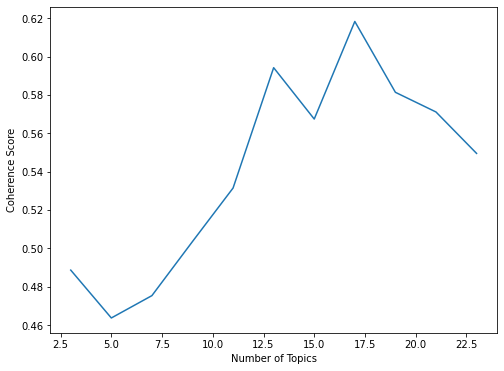

In [218]:
plt.figure(figsize=(8, 6))
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [284]:
df_topics_coh.describe()

,num_topics,coherence_score (c_v)
count,11.00000,11.000000
mean,13.00000,0.540386
std,6.63325,0.051611
min,3.00000,0.463649
25%,8.00000,0.496064
50%,13.00000,0.549478
75%,18.00000,0.576208
max,23.00000,0.618279


In [283]:
BEST_NUM_TOPICS = int(df_topics_coh.loc[df_topics_coh['coherence_score (c_v)'].idxmax()]['num_topics'])

BEST_NUM_TOPICS

17

## 1.4. Train LDA

In [231]:
lda_model_tuned = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     iterations=50,
                     num_topics=BEST_NUM_TOPICS,
                     passes=10)

## 1.5. Visualization

### Overview: Visualise Inter-Topic Distance and Word Relevancy

* The words shown in the graph below are chosen based on **Term Saliency** and **Word Relevancy**:
    * Quick Overiew: https://community.alteryx.com/t5/Data-Science/Getting-to-the-Point-with-Topic-Modeling-Part-3-Interpreting-the/ba-p/614992
    * Saliency:
        * The metric shows the most informative words for identifying topics across the corpus.
        * ![Term Saliency Formula](imgs/term_saliency.png)
        * Source: [Termite: Visualization Techniques for Assessing Textual Topic Models](https://idl.cs.washington.edu/files/2012-Termite-AVI.pdf)
        * Term Saliency relies on KL-Divergence:
            * Entropy, Cross Entropy and KL-Divergence: https://medium.com/intro-to-artificial-intelligence/entropy-cross-entropy-and-kl-divergence-b898f4587cf3
            * More on KL-Divergence: https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained
    * Relevancy:
        * The metric ranks terms within topics.
        * ![Term Relevancy Formula](imgs/term_relevancy.png)
        * ![Term Lift Formula](imgs/term_lift.png)
        * Source: [LDAvis: A method for visualizing and interpreting topics](https://aclanthology.org/W14-3110.pdf)

In [431]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model_tuned, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/amrgalal/.pyenv/versions/3.9.10/envs/topic_modeling/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/amrgalal/.pyenv/versions/3.9.10/envs/topic_modeling/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/amrgalal/.pyenv/versions/3.9.10/envs/topic_modeling/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/amrgalal/.pyenv/versions/3.9.10/envs/topic_modeling/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of i

* Circles represent topics.
* The bigger the circle, the more documents are associated to the topic. 
* The distance between the circles shows how related the topics are to each other.
* Dimensionality reduction is applied to be able to visualise the topics in 2D.

In [432]:
# preview pyLDAvis output
lda_display.topic_info.head(10)

,Term,Freq,Total,Category,logprob,loglift
14204,maxaxaxaxaxaxaxaxaxaxaxaxaxaxax,3518.0,3518.0,Default,30.0,30.0
139,would,6084.0,6084.0,Default,29.0,29.0
116,know,3491.0,3491.0,Default,28.0,28.0
266,file,1745.0,1745.0,Default,27.0,27.0
1197,please,1485.0,1485.0,Default,26.0,26.0
406,thanks,1221.0,1221.0,Default,25.0,25.0
371,anyone,1556.0,1556.0,Default,24.0,24.0
203,use,3303.0,3303.0,Default,23.0,23.0
86,new,2535.0,2535.0,Default,22.0,22.0
737,email,1227.0,1227.0,Default,21.0,21.0


### Visualize Topic-Words Relevancy

In [232]:
NUM_TOP_WORDS_PER_TOPIC = 5

In [341]:
# preview topics
lda_model_tuned.show_topics(num_topics=BEST_NUM_TOPICS,
                              num_words=5,
                              formatted=False)

[(0,
  [('maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 0.21952881),
   ('thanks', 0.047672343),
   ('please', 0.041108403),
   ('anyone', 0.032920267),
   ('email', 0.02744418)]),
 (1,
  [('would', 0.012057261),
   ('people', 0.011539721),
   ('one', 0.011131753),
   ('think', 0.008986796),
   ('say', 0.007100904)]),
 (2,
  [('game', 0.017976815),
   ('team', 0.0152627835),
   ('games', 0.012335203),
   ('year', 0.011331889),
   ('play', 0.010754187)]),
 (3,
  [('health', 0.017309675),
   ('use', 0.014337583),
   ('medical', 0.0137291085),
   ('pain', 0.010440599),
   ('among', 0.010352119)]),
 (4,
  [('one', 0.013354836),
   ('get', 0.01153738),
   ('like', 0.011054322),
   ('would', 0.009436658),
   ('good', 0.008883592)]),
 (5,
  [('government', 0.011479215),
   ('would', 0.008942299),
   ('gun', 0.008907681),
   ('people', 0.008382049),
   ('state', 0.007967008)]),
 (6,
  [('key', 0.017384103),
   ('use', 0.011960075),
   ('data', 0.008536391),
   ('chip', 0.008044769),
   ('system', 0.007910

In [402]:
# separate words from weights
dict_top_words_per_topic = {}
for topic_num, words_weights in lda_model_tuned.show_topics(num_topics=BEST_NUM_TOPICS,
                                                               num_words=NUM_TOP_WORDS_PER_TOPIC,
                                                               formatted=False):
    
    # unzip words from their weights
    words_list = list(zip(*words_weights))[0]
    
    dict_top_words_per_topic[topic_num] = list(words_list)
    
dict_top_words_per_topic

{0: ['maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 'thanks', 'please', 'anyone', 'email'],
 1: ['would', 'people', 'one', 'think', 'say'],
 2: ['game', 'team', 'games', 'year', 'play'],
 3: ['health', 'use', 'medical', 'pain', 'among'],
 4: ['one', 'get', 'like', 'would', 'good'],
 5: ['government', 'would', 'gun', 'people', 'state'],
 6: ['key', 'use', 'data', 'chip', 'system'],
 7: ['would', 'like', 'could', 'get', 'really'],
 8: ['said', 'one', 'people', 'went', 'know'],
 9: ['food', 'msg', 'dod', 'diet', 'day'],
 10: ['space', 'president', 'new', 'program', 'also'],
 11: ['windows', 'drive', 'use', 'system', 'card'],
 12: ['engine', 'water', 'oil', 'air', 'miles'],
 13: ['new', 'san', 'york', 'lost', 'francisco'],
 14: ['file', 'window', 'program', 'entry', 'output'],
 15: ['jesus', 'god', 'jews', 'armenian', 'turkish'],
 16: ['available', 'information', 'list', 'email', 'send']}

In [264]:
# Coherence model
cm = CoherenceModel(model=lda_model_tuned,
                    texts = df['text_tokenized'],
                    corpus=corpus,
                    dictionary=dictionary,
                    coherence='c_v')

coherence_per_topic = cm.get_coherence_per_topic()

In [343]:
coherence_per_topic

[0.59065207979149,
 0.5367081306737563,
 0.7364324402141096,
 0.588454057303073,
 0.4852214155646671,
 0.6292780889744211,
 0.5917436525795522,
 0.48431347853137485,
 0.6340494601567246,
 0.3048833780996979,
 0.48265371561187226,
 0.6452223575915448,
 0.35466744882226714,
 0.5218465116478251,
 0.6151575602374644,
 0.5421648566857911,
 0.7151608701122297]

#### Visualise Topics based on Topic Coherence, and words weights from LDA

In [477]:
df_topics = pd.DataFrame(data=zip(dict_top_words_per_topic.keys(), coherence_per_topic, dict_top_words_per_topic.values()),
                        columns=['topic', 'coherence', 'keywords'])
df_topics.head()

,topic,coherence,keywords
0,0,0.590652,"[maxaxaxaxaxaxaxaxaxaxaxaxaxaxax, thanks, please, anyone, email]"
1,1,0.536708,"[would, people, one, think, say]"
2,2,0.736432,"[game, team, games, year, play]"
3,3,0.588454,"[health, use, medical, pain, among]"
4,4,0.485221,"[one, get, like, would, good]"


<AxesSubplot:title={'center':'Topics coherence\n $C_v$'}>

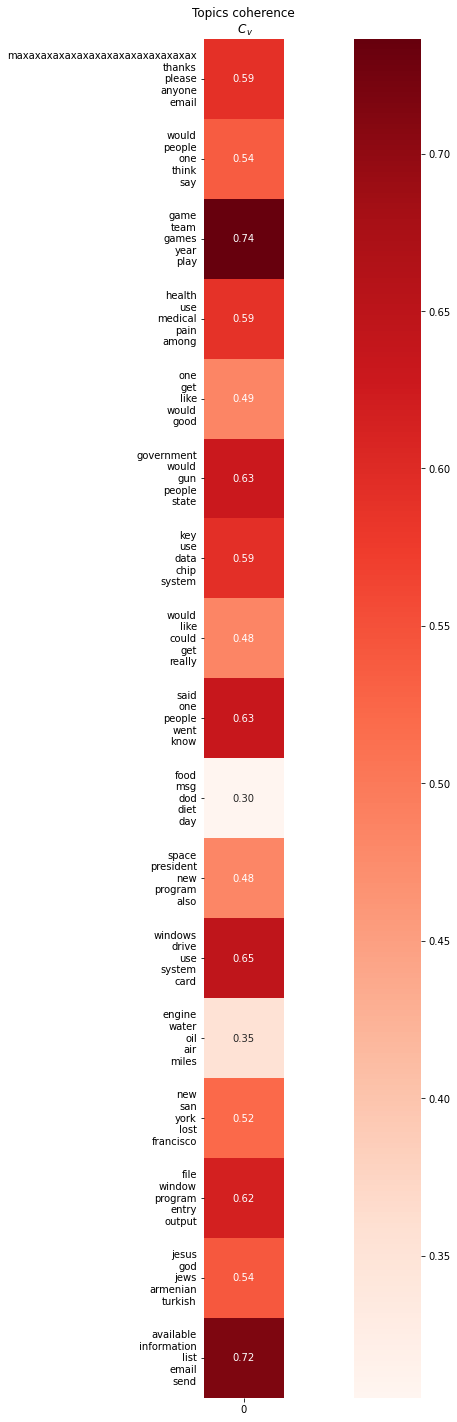

In [455]:
fig, ax = plt.subplots( figsize=(25, 25) )
ax.set_title("Topics coherence\n $C_v$")

# sort topics by coherence score
df_topics_sorted_coh = df_topics.sort_values('coherence', ascending=False)

sns.heatmap(data=df_topics['coherence'].values.reshape(-1, 1),
            yticklabels=df_topics['keywords'].apply(lambda x: '\n'.join(x)),
            annot=True,
            square=True,
            cmap='Reds',
            fmt='.2f',
            linecolor='black',
)

#### Visualise Topics based on Coherence, and Word Relevancy

In [413]:
# preview pyLDAvis output
lda_display.topic_info.head(10)

,Term,Freq,Total,Category,logprob,loglift
14204,maxaxaxaxaxaxaxaxaxaxaxaxaxaxax,3519.0,3519.0,Default,30.0,30.0
139,would,6084.0,6084.0,Default,29.0,29.0
116,know,3491.0,3491.0,Default,28.0,28.0
266,file,1745.0,1745.0,Default,27.0,27.0
1197,please,1485.0,1485.0,Default,26.0,26.0
406,thanks,1221.0,1221.0,Default,25.0,25.0
371,anyone,1556.0,1556.0,Default,24.0,24.0
203,use,3303.0,3303.0,Default,23.0,23.0
86,new,2536.0,2536.0,Default,22.0,22.0
737,email,1227.0,1227.0,Default,21.0,21.0


In [443]:
df_topic_terms_relevance = pd.DataFrame()

# smaller lambda leads to topic-exculisive terms, but is susceptible to fetch anomalies
lambd = 0.1

for i in range(1, BEST_NUM_TOPICS+1):
    # separate topic i terms
    topic = lda_display.topic_info[lda_display.topic_info.Category == 'Topic'+str(i)].copy()
    
    # calculate topic i terms relevancy
    topic['relevance'] = lambd*topic['logprob'] + (1-lambd)*topic['loglift']
    
    # get top NUM_TOP_WORDS_PER_TOPIC terms
    top_relevant_terms = topic.sort_values(by='relevance', ascending=False).Term[:NUM_TOP_WORDS_PER_TOPIC].values
    
    # append selected terms
    df_topic_terms_relevance = pd.concat([df_topic_terms_relevance,
                                            pd.DataFrame.from_records([{'topic': i-1, 'keywords_by_relevance': top_relevant_terms}])])
    
df_topic_terms_relevance.reset_index(inplace=True, drop=True)

print(f"dataframe shape: {df_topic_terms_relevance.shape}")
df_topic_terms_relevance.tail()

dataframe shape: (17, 2)


,topic,keywords_by_relevance
12,12,"[engine, candida, borland, oil, exhaust]"
13,13,"[dog, cubs, yankees, sox, allocation]"
14,14,"[window, widget, int, client, null]"
15,15,"[turkish, greek, jesus, turkey, jews]"
16,16,"[entries, contest, mailing, anonymous, guidelines]"


In [478]:
# merge top relevant terms
df_topics = pd.merge(
    left=df_topics,
    right=df_topic_terms_relevance,
    left_on='topic',
    right_on='topic',
)

print(f"dataframe shape: {df_topics.shape}")
df_topics.head()

dataframe shape: (17, 4)


,topic,coherence,keywords,keywords_by_relevance
0,0,0.590652,"[maxaxaxaxaxaxaxaxaxaxaxaxaxaxax, thanks, please, anyone, email]","[maxaxaxaxaxaxaxaxaxaxaxaxaxaxax, pointer, advance, toyota, gifs]"
1,1,0.536708,"[would, people, one, think, say]","[truth, believe, argument, christianity, moral]"
2,2,0.736432,"[game, team, games, year, play]","[game, season, players, league, team]"
3,3,0.588454,"[health, use, medical, pain, among]","[disease, medical, patients, diseases, adl]"
4,4,0.485221,"[one, get, like, would, good]","[car, cars, nec, wire, bikes]"


### Visualise Documents by Dominant Topics

In [447]:
# preview topics for doc 1
lda_model_tuned.get_document_topics(corpus[0])

[(1, 0.43112642), (5, 0.32567912), (10, 0.065627016), (15, 0.16559733)]

In [448]:
# extract the dominant topic 
sorted(lda_model_tuned.get_document_topics(corpus[0]), key=lambda x: x[1], reverse=True)[0][0]

1

In [449]:
func_get_dominant_topic = lambda x: sorted(lda_model_tuned.get_document_topics(x), key=lambda x: x[1], reverse=True)[0][0]

text_dominant_topic = [ func_get_dominant_topic(x) for x in corpus ]

print(f"preview dominant topics: {text_dominant_topic[:10]}")

preview dominant topics: [1, 1, 5, 4, 2, 1, 11, 1, 1, 4]


In [450]:
# sanity check the documents lengths

assert df.shape[0] == len(corpus) == len(text_dominant_topic)

In [451]:
df["dominant_topic"] = text_dominant_topic

print(f"dataframe shape: {df.shape}")
df.head()

dataframe shape: (10974, 5)


,text,category,text_preprocessed,text_tokenized,dominant_topic
0,Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statemen...,17,well sure story nad seem biased disagree statement media ruin israels reputation rediculous medi...,"[well, sure, story, nad, seem, biased, disagree, statement, media, ruin, israels, reputation, re...",1
1,"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism...",0,yeah expect people read faq etc actually accept hard atheism need little leap faith jimmy logic ...,"[yeah, expect, people, read, faq, etc, actually, accept, hard, atheism, need, little, leap, fait...",1
2,"Although I realize that principle is not one of your strongest\npoints, I would still like to kn...",17,although realize principle one strongest points would still like know ask question sort arab cou...,"[although, realize, principle, one, strongest, points, would, still, like, know, ask, question, ...",5
3,"Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it? ATT's...",11,notwithstanding legitimate fuss proposal much change atts last product area priced suspect clipp...,"[notwithstanding, legitimate, fuss, proposal, much, change, atts, last, product, area, priced, s...",4
4,"Well, I will have to change the scoring on my playoff pool. Unfortunately\nI don't have time ri...",10,well change scoring playoff pool unfortunately time right now certainly post new scoring rules t...,"[well, change, scoring, playoff, pool, unfortunately, time, right, now, certainly, post, new, sc...",2


In [476]:
# count documents per topic
df_doc_per_topic_count = df.groupby('dominant_topic').aggregate(['count'])['text'].reset_index()

df_doc_per_topic_count.rename(columns={'dominant_topic': 'topic'}, inplace=True)

print(f"dataframe shape: {df_doc_per_topic_count.shape}")
df_doc_per_topic_count.head()

dataframe shape: (17, 2)


,topic,count
0,0,308
1,1,2537
2,2,698
3,3,97
4,4,2455


In [479]:
# merge doc count per topic
df_topics = pd.merge(
    left=df_topics,
    right=df_doc_per_topic_count,
    left_on='topic',
    right_on='topic',
)

df_topics.rename(columns={'count': 'num_documents'}, inplace=True)

print(f"dataframe shape: {df_topics.shape}")
df_topics.head()

dataframe shape: (17, 5)


,topic,coherence,keywords,keywords_by_relevance,num_documents
0,0,0.590652,"[maxaxaxaxaxaxaxaxaxaxaxaxaxaxax, thanks, please, anyone, email]","[maxaxaxaxaxaxaxaxaxaxaxaxaxaxax, pointer, advance, toyota, gifs]",308
1,1,0.536708,"[would, people, one, think, say]","[truth, believe, argument, christianity, moral]",2537
2,2,0.736432,"[game, team, games, year, play]","[game, season, players, league, team]",698
3,3,0.588454,"[health, use, medical, pain, among]","[disease, medical, patients, diseases, adl]",97
4,4,0.485221,"[one, get, like, would, good]","[car, cars, nec, wire, bikes]",2455


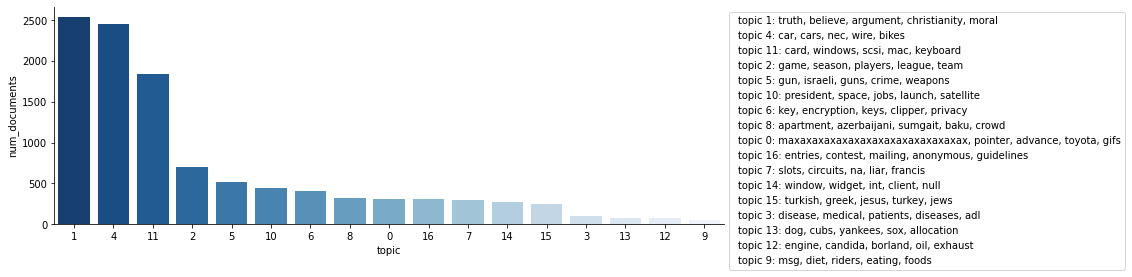

In [537]:
plt.figure(figsize=(12, 4))

df_topics_sorted_num_docs = df_topics.sort_values('num_documents', ascending=False)

plt.xlabel('topic')
plt.ylabel('number of documents')


sns.barplot(x='topic',
            y='num_documents',
            data=df_topics_sorted_num_docs,
            order=df_topics_sorted_num_docs['topic'],
            palette='Blues_r'
)

legend = (
    'topic ' +\
    df_topics_sorted_num_docs['topic'].astype(str) +\
    ': ' +\
    df_topics_sorted_num_docs['keywords_by_relevance'].apply(lambda x: ', '.join(x))
)

plt.legend(labels=legend, loc=2, bbox_to_anchor=(1, 1), handletextpad=0.5, handlelength=0)
sns.despine()

### Topics

In [323]:
df_topics = pd.DataFrame(data=zip(range(len(coherence_per_topic)), coherence_per_topic),
                        columns=['topic', 'coherence'])

df_topics.head()

,topic,coherence
0,0,0.590652
1,1,0.536708
2,2,0.736432
3,3,0.588454
4,4,0.485221


In [324]:
df_topics = pd.merge(left=df_topics,
                     right=df['dominant_topic'].value_counts().rename('doc_count'),
                     left_on='topic',
                     right_index=True)
df_topics.head()

,topic,coherence,doc_count
0,0,0.590652,309
1,1,0.536708,2537
2,2,0.736432,699
3,3,0.588454,97
4,4,0.485221,2456
